In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt 

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LeakyReLU
from os.path import join
from os import environ

In [2]:
Autoencoder = tf.keras.models.load_model('k_fold_best_model_new_architecture_test3')

In [3]:
home=environ['HOME']
folder1='GRIMech_CH4_models_RS3_15_trajectories'
folder2='Datasets'

cantera_species=pd.read_csv(join(home, folder1,folder2,'State_space_cte_pressure_T1418_st-quarter_phi_8.csv'))
cantera_species=pd.DataFrame(cantera_species)

cantera_sources=pd.read_csv(join(home,folder1,folder2,'Reaction_rates_cte_pressure_T1418_st-quarter_phi_8.csv'))
cantera_sources=pd.DataFrame(cantera_sources)

maximum_values=pd.read_csv(join(home,folder1,folder2,'maximum_values_T1418.csv'))
maximum_values=pd.DataFrame(maximum_values)

In [4]:
def hydrogen_data_clean_shift_grimech_cantera(cantera_species,cantera_sources,maximum_values):
    cantera_sources=cantera_sources.add_suffix('w')
    cantera_sources=cantera_sources.iloc[:,1:] #for taking out the timestep as data 
    
    cantera_time=cantera_species.iloc[:,1]
    cantera_temperature=cantera_species.iloc[:,2]
    cantera_pressure=cantera_species.iloc[:,3]
    
    cantera_species_fractions=cantera_species.iloc[:,4:]
    print(np.shape(cantera_species_fractions))
    
    cantera_species_fractions=cantera_species_fractions.loc[:,(cantera_species!=0).any(axis=0)]
    cantera_species_fractions=cantera_species_fractions.loc[:, (cantera_species != cantera_species.iloc[0]).any()]
    print(np.shape(cantera_species_fractions))
    
    n_columns_mass_fraction=np.shape(cantera_species_fractions)[1]
    print(n_columns_mass_fraction)
    
    cantera_sources=cantera_sources.loc[:,(cantera_sources!=0).any(axis=0)]
    cantera_sources=cantera_sources.loc[:, (cantera_sources != cantera_sources.iloc[0]).any()]
    
    print(np.shape(cantera_sources))
    n_columns_source=np.shape(cantera_sources)[1]
    print(n_columns_source)
    
    cantera_data=pd.concat([cantera_time, cantera_temperature,cantera_species_fractions,cantera_sources],axis=1)

    maximum_values=maximum_values.iloc[:,1:]
    maximum_values=pd.concat([maximum_values.iloc[:,0:2],maximum_values.iloc[:,3:]],axis=1)
    #print(maximum_values)
    
    maximum_values=maximum_values.to_numpy()
    print(np.shape(maximum_values))
    
    iterations=np.shape(cantera_data)[1]
    print(iterations)
    print(np.shape(cantera_data))
    
    #cantera_data.divide(maximum_values)
    for j in range(iterations):
        cantera_data.iloc[:,j]=cantera_data.iloc[:,j]/(maximum_values[0,j])
        #print(maximum_values[0,j])
    
    cantera_data_shift=cantera_data.loc[1:,:]
    cantera_data_shift=cantera_data_shift.add_suffix('shift')
    
    cantera_data=cantera_data.reset_index()
    cantera_data_shift=cantera_data_shift.reset_index()
    
    cantera_data=cantera_data.iloc[:,1:]
    cantera_data_shift=cantera_data_shift.iloc[:,1:]

    cantera_data=cantera_data.iloc[0:(np.shape(cantera_data_shift)[0]),:]
    
    data_all=pd.concat([cantera_data, cantera_data_shift], axis=1)

    columns=data_all.columns.to_list()
    
    return data_all, n_columns_source, n_columns_mass_fraction, columns

In [5]:
dataset, n_columns_source, n_columns_mass_fraction, columns=hydrogen_data_clean_shift_grimech_cantera(cantera_species,cantera_sources,maximum_values)

(120000, 49)
(120000, 30)
30
(120000, 30)
30
(1, 62)
62
(120000, 62)


In [6]:
results=Autoencoder.decoder(Autoencoder.lat_activation(Autoencoder.encoder(dataset.iloc[:,1:2+n_columns_mass_fraction].to_numpy()))).numpy()

In [7]:
latent_space=Autoencoder.lat_activation(Autoencoder.encoder(dataset.iloc[:,1:2+n_columns_mass_fraction].to_numpy())).numpy()

In [8]:
corr_dataset=dataset.iloc[:,1:2+n_columns_mass_fraction+n_columns_source]
corr_columns=corr_dataset.columns.to_list()
corr_dataset

,T[K],H2,H,O,O2,OH,H2O,HO2,H2O2,C,...,CH3OHw,C2Hw,C2H2w,C2H3w,C2H4w,C2H5w,C2H6w,HCCOw,CH2COw,HCCOHw
0,0.405009,2.955530e-11,1.500399e-09,3.744474e-11,0.846896,2.099633e-11,3.157602e-13,0.000001,1.441943e-09,3.471111e-35,...,8.445652e-10,5.419653e-29,2.272142e-17,2.206733e-18,1.471080e-08,1.196103e-05,-8.900524e-04,2.178789e-28,1.500028e-28,8.567921e-30
1,0.405009,1.144741e-10,2.855525e-09,1.412753e-10,0.846896,8.074650e-11,2.346449e-12,0.000002,5.764779e-09,1.633554e-33,...,3.264399e-09,9.021694e-28,9.169431e-17,1.459148e-17,2.983665e-08,1.229310e-05,-8.902941e-04,6.259715e-27,3.927156e-27,2.535145e-28
2,0.405009,2.494498e-10,4.079969e-09,2.997891e-10,0.846896,1.745435e-10,7.618240e-12,0.000004,1.296666e-08,4.380042e-32,...,7.098486e-09,4.622771e-27,2.082095e-16,4.439010e-17,4.537479e-08,1.262191e-05,-8.905369e-04,4.418269e-26,2.783073e-26,1.845304e-27
3,0.405009,4.296283e-10,5.187088e-09,5.027735e-10,0.846896,2.979645e-10,1.748779e-11,0.000005,2.304524e-08,3.338852e-31,...,1.219995e-08,1.476541e-26,3.735574e-16,9.733291e-17,6.131998e-08,1.294566e-05,-8.907802e-04,1.744905e-25,1.127973e-25,7.502462e-27
4,0.405009,6.506809e-10,6.188818e-09,7.415658e-10,0.846896,4.469807e-10,3.312371e-11,0.000006,3.599815e-08,-1.607936e-32,...,1.843816e-08,3.590822e-26,5.890021e-16,1.780214e-16,7.766504e-08,1.326288e-05,-8.910231e-04,5.000770e-25,3.342556e-25,2.211636e-26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119994,0.969303,8.983799e-01,1.000000e+00,6.091488e-01,0.066557,8.794063e-01,9.434736e-01,0.025977,2.743066e-02,2.385998e-06,...,-1.568280e-20,-6.451926e-22,-5.236895e-23,-1.049890e-25,-4.932302e-27,-1.375179e-28,-6.788589e-31,-7.916894e-21,3.632149e-22,-4.621087e-22
119995,0.969303,8.983799e-01,1.000000e+00,6.091488e-01,0.066557,8.794063e-01,9.434736e-01,0.025977,2.743066e-02,2.385998e-06,...,-1.571821e-20,-6.439083e-22,-5.243513e-23,-1.049423e-25,-4.935730e-27,-1.375131e-28,-6.788427e-31,-7.911340e-21,3.627476e-22,-4.621758e-22
119996,0.969303,8.983799e-01,1.000000e+00,6.091488e-01,0.066557,8.794063e-01,9.434736e-01,0.025977,2.743066e-02,2.385998e-06,...,-1.571028e-20,-6.435962e-22,-5.243683e-23,-1.049946e-25,-4.931415e-27,-1.375043e-28,-6.790760e-31,-7.913069e-21,3.630157e-22,-4.621066e-22
119997,0.969303,8.983799e-01,1.000000e+00,6.091488e-01,0.066557,8.794063e-01,9.434736e-01,0.025977,2.743066e-02,2.385998e-06,...,-1.570340e-20,-6.441064e-22,-5.239273e-23,-1.049643e-25,-4.930950e-27,-1.375154e-28,-6.792063e-31,-7.916825e-21,3.632043e-22,-4.620374e-22


In [9]:
iterations=np.shape(corr_dataset)[1]

reduced_size=np.shape(latent_space)[1]

from scipy import stats 

if reduced_size==1:
    corr_indexes=np.zeros(iterations) #rows, columns
    corr_indexes=np.array([corr_indexes])
    
    for j in range(iterations):
        corr_indexes[:,j],_=stats.kendalltau(corr_dataset.iloc[:,j],latent_space)
    corr_indexes=pd.DataFrame(corr_indexes, columns=corr_columns)
else: 
    
    corr_indexes=np.zeros((reduced_size,iterations)) #rows, columns
    
    for k in range(reduced_size):
        for j in range(iterations):
            corr_indexes[k,j],_=stats.kendalltau(corr_dataset.iloc[:,j],latent_space[:,k])
    corr_indexes=pd.DataFrame(corr_indexes, columns=corr_columns)

OH     0.880605
H      0.880573
CO2    0.880217
O      0.880203
H2     0.879436
Name: 0, dtype: float64
CH3OH    0.898556
C2H4     0.898275
C2H5     0.897625
CH3O     0.897291
CH3      0.897202
Name: 1, dtype: float64
CH3     0.900453
CH3O    0.900339
C2H5    0.900058
C2H4    0.899407
C2H3    0.898768
Name: 2, dtype: float64


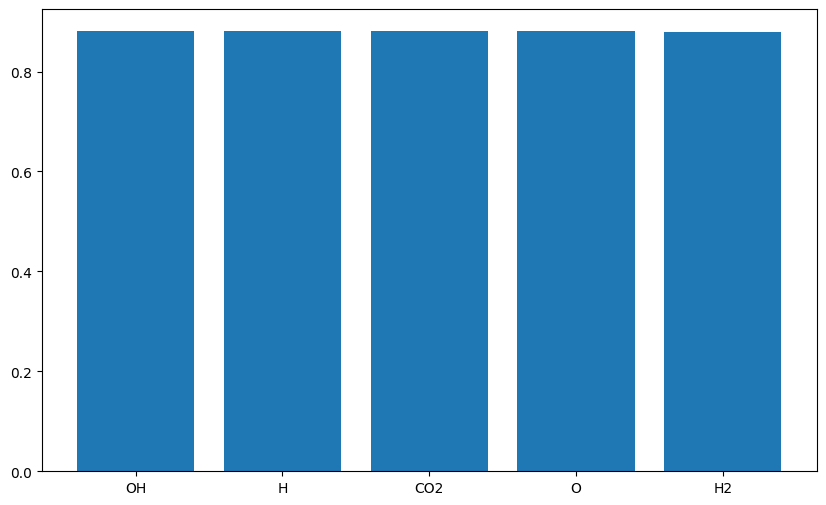

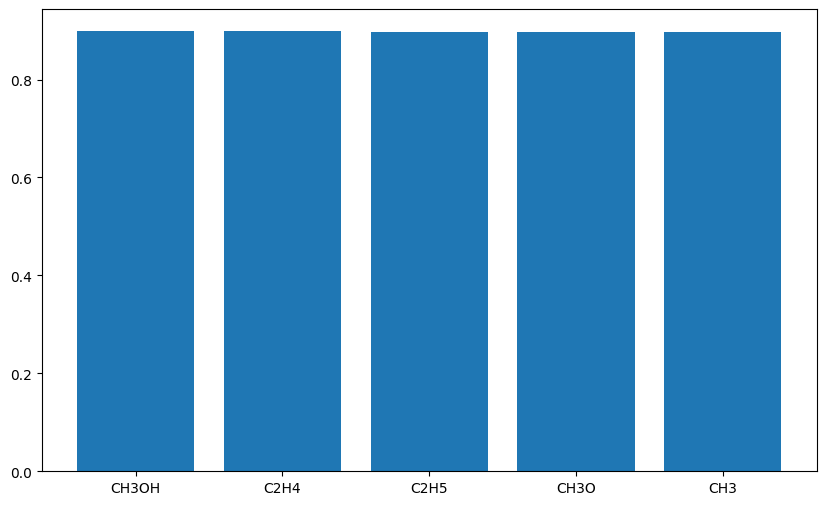

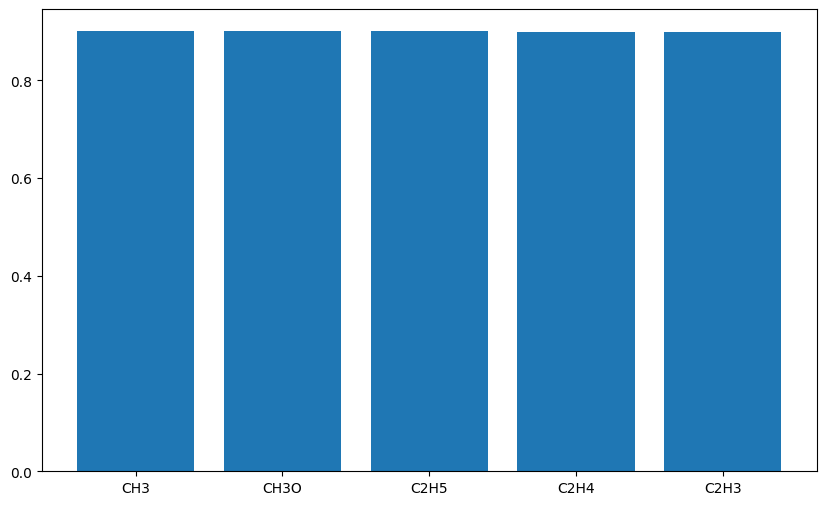

In [10]:
latent_features=[]

for m in range(reduced_size):
    
    indexes=corr_indexes.iloc[m,:].sort_values(ascending=False)
    indexes=indexes.iloc[0:5]
    x=indexes.keys()
    latent_features.append(x[0])
    height=indexes.iloc[:].to_numpy()
    plt.figure(m,figsize=(10, 6))
    plt.bar(x,height)
    
    #axes=indexes.plot.bar(x='Chemical Specie', y='Corellation Index',rot=reduced_size, subplots=True)
    #axes[1].legend(loc=reduced_size)
    print(indexes)

In [11]:
latent_features

['OH', 'CH3OH', 'CH3']

In [12]:
for j in range(len(latent_features)):
    if j==0:
        regression_inputs=dataset.loc[:,latent_features[j]]
    else:
        regression_inputs=pd.concat([regression_inputs,dataset.loc[:,latent_features[j]]],axis=1)

In [13]:
output_start=3+n_columns_mass_fraction+n_columns_source
output_end=output_start+n_columns_mass_fraction+1
outputs=dataset.iloc[:,output_start:output_end]
outputs

,T[K]shift,H2shift,Hshift,Oshift,O2shift,OHshift,H2Oshift,HO2shift,H2O2shift,Cshift,...,CH3OHshift,C2Hshift,C2H2shift,C2H3shift,C2H4shift,C2H5shift,C2H6shift,HCCOshift,CH2COshift,HCCOHshift
0,0.405009,1.144741e-10,2.855525e-09,1.412753e-10,0.846896,8.074650e-11,2.346449e-12,0.000002,5.764779e-09,1.633554e-33,...,4.917901e-12,3.519631e-30,4.515457e-19,6.508123e-20,1.009221e-10,1.591301e-07,9.646949e-01,2.062326e-29,1.194217e-29,7.573196e-31
1,0.405009,2.494498e-10,4.079969e-09,2.997891e-10,0.846896,1.745435e-10,7.618240e-12,0.000004,1.296666e-08,4.380042e-32,...,1.603279e-11,2.738131e-29,1.520502e-18,2.924377e-19,2.291540e-10,2.420009e-07,9.646942e-01,2.205222e-28,1.276333e-28,8.327363e-30
2,0.405009,4.296283e-10,5.187088e-09,5.027735e-10,0.846896,2.979645e-10,1.748779e-11,0.000005,2.304524e-08,3.338852e-31,...,3.697270e-11,1.154652e-28,3.621279e-18,8.538202e-19,4.111145e-10,3.270426e-07,9.646934e-01,1.146585e-27,6.728947e-28,4.438154e-29
3,0.405009,6.506809e-10,6.188818e-09,7.415658e-10,0.846896,4.469807e-10,3.312371e-11,0.000006,3.599815e-08,-1.607936e-32,...,7.038032e-11,3.505438e-28,7.116194e-18,1.956064e-18,6.481818e-10,4.142170e-07,9.646927e-01,4.082802e-27,2.459865e-27,1.618591e-28
4,0.405009,9.087297e-10,7.095853e-09,1.008814e-09,0.846896,6.179268e-10,5.552838e-11,0.000007,5.182309e-08,2.380916e-31,...,1.186198e-10,8.632974e-28,1.237653e-17,3.840205e-18,9.417052e-10,5.034766e-07,9.646919e-01,1.145724e-26,7.112331e-27,4.649370e-28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119994,0.969303,8.983799e-01,1.000000e+00,6.091488e-01,0.066557,8.794063e-01,9.434736e-01,0.025977,2.743066e-02,2.385998e-06,...,6.096772e-10,4.233818e-11,7.858512e-12,1.382815e-14,1.864840e-16,2.387228e-18,2.868549e-21,9.269314e-10,2.915594e-10,1.283737e-11
119995,0.969303,8.983799e-01,1.000000e+00,6.091488e-01,0.066557,8.794063e-01,9.434736e-01,0.025977,2.743066e-02,2.385998e-06,...,6.096772e-10,4.233818e-11,7.858512e-12,1.382815e-14,1.864840e-16,2.387228e-18,2.868549e-21,9.269314e-10,2.915594e-10,1.283737e-11
119996,0.969303,8.983799e-01,1.000000e+00,6.091488e-01,0.066557,8.794063e-01,9.434736e-01,0.025977,2.743066e-02,2.385998e-06,...,6.096772e-10,4.233818e-11,7.858512e-12,1.382815e-14,1.864840e-16,2.387228e-18,2.868549e-21,9.269314e-10,2.915594e-10,1.283737e-11
119997,0.969303,8.983799e-01,1.000000e+00,6.091488e-01,0.066557,8.794063e-01,9.434736e-01,0.025977,2.743066e-02,2.385998e-06,...,6.096772e-10,4.233818e-11,7.858512e-12,1.382815e-14,1.864840e-16,2.387228e-18,2.868549e-21,9.269314e-10,2.915594e-10,1.283737e-11


In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(regression_inputs, outputs, test_size=0.1, random_state=42)

out_columns=columns[1:2+n_columns_mass_fraction]

In [15]:
iterations=np.shape(outputs)[1]
inputs=np.shape(regression_inputs)[1]

coefficients_ch=np.zeros((iterations,inputs))
intercepts_ch=np.zeros((iterations))
scores_ch=np.zeros((iterations))

results_ch=np.zeros((iterations,inputs))

In [16]:
cols=np.shape(regression_inputs)[1]
rows=np.shape(outputs)[1]
coefficients=np.zeros((rows,cols))
print(np.shape(coefficients))

intercepts=np.zeros((rows,1))
print(np.shape(intercepts))

scores=np.zeros((rows,1))

(31, 3)
(31, 1)


In [18]:
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RepeatedKFold

n_split=5
n_repeats=3

for k in range(rows):

    for train_index,test_index in RepeatedKFold(n_splits=n_split, n_repeats=n_repeats,random_state=42).split(X_train):
    
        x_train,x_test=X_train.iloc[train_index],X_train.iloc[test_index]
        Y_train,Y_test=y_train.iloc[train_index],y_train.iloc[test_index]
    
        reg = LinearRegression().fit(x_train, Y_train.iloc[:,k])
        
        result = permutation_importance(reg, x_test, Y_test.iloc[:,k], n_repeats=10, random_state=42, n_jobs=2)
        results_ch[k,:]=result.importances_mean
        
        score=reg.score(x_train, Y_train.iloc[:,k])
        scores_ch[k]=score
        
        coeff=reg.coef_
        coefficients_ch[k,:]=coeff
        
        intercept=reg.intercept_
        intercepts_ch[k]= intercept

In [19]:
results_ch_dataframe=pd.DataFrame(results_ch, index=outputs.columns.to_list())
results_ch_dataframe

,0,1,2
T[K]shift,2.120412e+00,3.718900e-03,5.598009e-03
H2shift,2.068157e+00,1.195678e-04,8.892388e-03
Hshift,1.999270e+00,1.837303e-06,4.610731e-06
Oshift,1.999632e+00,9.004138e-06,3.382736e-05
O2shift,2.087353e+00,1.709327e-03,3.208325e-03
OHshift,1.999731e+00,2.295670e-08,6.763270e-08
H2Oshift,2.127157e+00,3.961048e-03,7.032825e-03
HO2shift,6.957650e-03,1.450834e+00,1.383786e-01
H2O2shift,6.542982e-02,1.849661e+00,7.107667e-02
Cshift,3.890749e-04,5.649388e-02,1.485608e-01


In [20]:
results_ch_dataframe.to_csv('permutation_importance_scores_phi8.csv')

In [21]:
iterations=np.shape(results_ch)[0]

for i in range(iterations):
    summ=results_ch_dataframe.iloc[i,:].sum()
    results_ch_dataframe.iloc[i,:]=results_ch_dataframe.iloc[i,:]/summ

In [22]:
results_ch_dataframe

,0,1,2
T[K]shift,9.956253e-01,1.746184e-03,2.628507e-03
H2shift,9.956614e-01,5.756286e-05,4.281013e-03
Hshift,9.999968e-01,9.189840e-07,2.306200e-06
Oshift,9.999786e-01,4.502800e-06,1.691643e-05
O2shift,9.976496e-01,8.169723e-04,1.533418e-03
OHshift,1.000000e+00,1.147989e-08,3.382090e-08
H2Oshift,9.948582e-01,1.852558e-03,3.289209e-03
HO2shift,4.358965e-03,9.089469e-01,8.669415e-02
H2O2shift,3.294275e-02,9.312714e-01,3.578584e-02
Cshift,1.893827e-03,2.749847e-01,7.231214e-01


In [23]:
x=results_ch_dataframe.index
x=list(dataset.iloc[:,1:2+n_columns_mass_fraction].columns.values)

y1=results_ch_dataframe.iloc[:,0]
y2=results_ch_dataframe.iloc[:,1]
y3=results_ch_dataframe.iloc[:,2]

In [24]:
x_pos =np.arange(len(x))
x_pos=x_pos+2

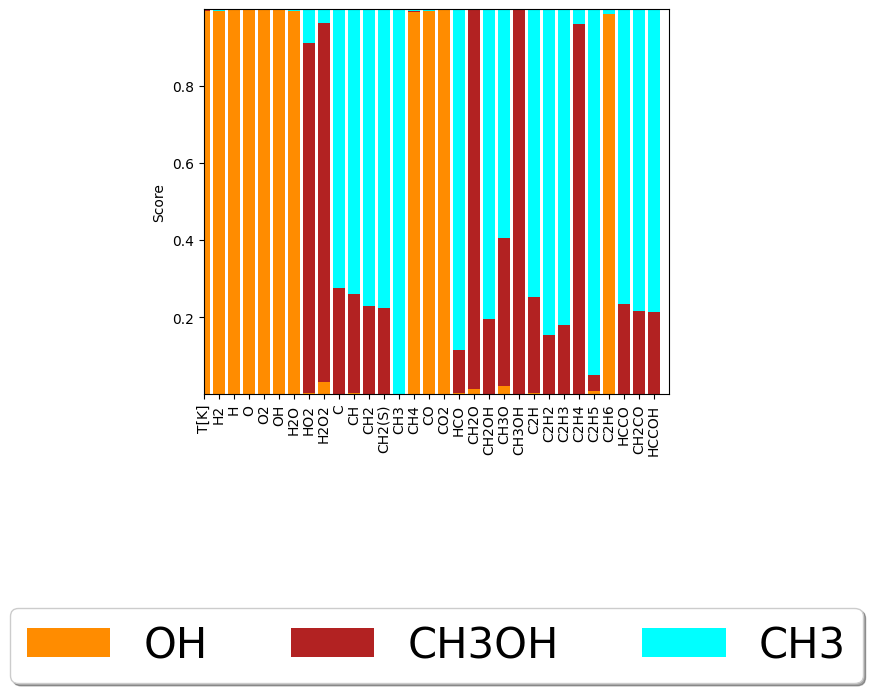

In [25]:
n = len(x)

fig, ax = plt.subplots(figsize=(n//5,5))  # Changing figsize depending upon data

# Example data
x_pos = np.arange(n)


ax.bar(x_pos, y1, align='center', color='darkorange', ecolor='black',label=latent_features[0])
ax.bar(x_pos, y2,bottom=y1, align='center', color='firebrick', ecolor='black',label=latent_features[1])
ax.bar(x_pos, y3,bottom=(y1+y2), align='center', color='cyan', ecolor='black',label=latent_features[2])
ax.set_xticks(x_pos)
ax.set_xticklabels([str(x) for x in x], rotation=90)
ax.set_ylabel('Score')
ax.set_xlim(0, n)

lgd=ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.5),
          fancybox=True, shadow=True, ncol=5, fontsize=30)

fig.savefig('permutation_importance_phi8.png',dpi=400, bbox_extra_artists=(lgd,), bbox_inches='tight')